In [20]:
from micromind import Metric

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import dataset.cifar100CUSTOM as cifar100CUSTOM

import os
import random
import importlib
import numpy as np

from tqdm import tqdm

batch_size = 64

In [84]:
from micromind import MicroMind
from micromind.networks import PhiNet

import torch
import torch.nn as nn

model_path = "../code/finetunecifar100/pretrained/v7/state_dict.pth.tar"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input = 344
        self.output = 100

        self.modules["feature_extractor"] = PhiNet(
            input_shape=(3, 224, 224),
            alpha=0.9,
            num_layers=7,
            beta=0.5,
            t_zero=4.0,
            include_top=False,
            num_classes=1000,
            compatibility=False,
            divisor=8,
            downsampling_layers=[4,5,7]
        )

        # Taking away the classifier from pretrained model
        pretrained_dict = torch.load(model_path, map_location=device)
        model_dict = {}
        for k, v in pretrained_dict.items():
            if "classifier" not in k:
                model_dict[k] = v
        self.modules['feature_extractor'].load_state_dict(model_dict)        
        for _, param in self.modules["feature_extractor"].named_parameters():    
            param.requires_grad = False

        self.modules["flattener"] = nn.Sequential(                          
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )        

        self.modules["classifier"] = nn.Sequential(                          
            nn.Linear(self.input, self.output)               
        )    

        # self.modules["classifier"].load_state_dict(pretrained_dict["classifier"])

    def forward(self, batch):        
        # x = self.modules["feature_extractor"](batch)    
        x = self.modules["classifier"](x)    
        return x

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])                   
        

Running on the MPS


In [76]:
train_transform = transforms.Compose(
        [
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True)
        ] 
    )

trainset = cifar100CUSTOM.CIFAR100CUSTOM(
    root="../_data/cifar-100", train=True, download=True, coarse=False, transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
test_transform = transforms.Compose(
        [
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True), 
        ] 
    )

testset = cifar100CUSTOM.CIFAR100CUSTOM(
    root="../_data/cifar-100", train=False, download=True, coarse=True
)

test_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
model = ImageClassification()

In [86]:
# creating tensors 
x = torch.tensor([]) 
y = torch.tensor([]) 
  
# printing above created tensors 
print("Tensor x:", x) 
print("Tensor y:", y) 
  
# join above tensor using "torch.stack()" 
print("join tensors:") 
t = torch.stack((x,y)) 
print(t)

Tensor x: tensor([])
Tensor y: tensor([])
join tensors:
tensor([], size=(2, 0))


In [87]:
device = 'mps'

model.modules.to(device)
it = iter(train_loader)

batch = next(it)
batch = [x.to(device) for x in batch]

mid = model.modules["feature_extractor"](batch[0]).to(device)
mid = model.modules["flattener"](mid).to(device)
x = model.modules["classifier"](mid).to(device)
print(x.shape)
y = batch[1]

for j in range(780):    

    print(j)
    batch = next(it)
    batch = [x.to(device) for x in batch]

    output = model.modules["feature_extractor"](batch[0]).to(device)
    output = model.modules["flattener"](output).to(device)
    output = model.modules["classifier"](output).to(device)
    labels = batch[1].to(device)

    x = torch.cat((x, output))
    y = torch.cat((y, labels))    


torch.Size([64, 100])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


In [88]:
print(len(x))
print(len(y))

49984
49984


In [89]:
print(x.shape)
print(y.shape)

torch.Size([49984, 100])
torch.Size([49984])


In [90]:
predicted = x.to('cpu').detach().numpy()
predicted = np.argmax(predicted, axis=1)
labels = y.to('cpu').detach().numpy()

['aquatic', 'plants', 'food', 'houshold', 'insects', 'outdoor_scenes', 'large_animals', 'medium_animals', 'vehicles', 'other']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([ 482,  428,  324,  424,  524,  633,  260,  459,  515,  390,  576,
        638,  242,  704,  688,  413,  587,  251,  700,  453,  474,  565,
        377,  149, 1070,  675,  501,  336,  712,  326,  453,  417,  439,
        687,  144,  967,  459,  135,  971,  708,  207,  524,  315,  605,
        974,  400,  405,  533,  640,  411,  391,  484,  907,  333,  632,
        397,  541,  522,  483,  793,  887,  556,  465,  349,  4

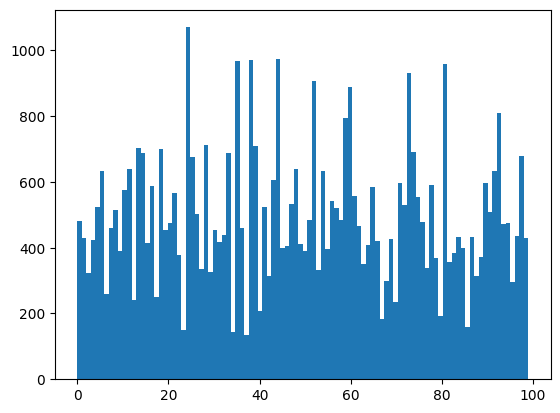

In [94]:
import matplotlib.pyplot as plt
plt.hist(predicted, bins=100)
classes = ["aquatic", "plants", "food", "houshold", "insects", "outdoor_scenes", "large_animals", "medium_animals", "vehicles", "other"]

print(classes)
print(np.unique(predicted, return_counts=True))


In [95]:
clustering_mapping = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 4, 41: 4, 42: 4, 43: 4, 44: 4, 45: 4, 46: 4, 47: 4, 48: 4, 49: 4, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 6, 61: 6, 62: 6, 63: 6, 64: 6, 65: 6, 66: 6, 67: 6, 68: 6, 69: 6, 70: 7, 71: 7, 72: 7, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7, 79: 7, 80: 8, 81: 8, 82: 8, 83: 8, 84: 8, 85: 8, 86: 8, 87: 8, 88: 8, 89: 8, 90: 9, 91: 9, 92: 9, 93: 9, 94: 9, 95: 9, 96: 9, 97: 9, 98: 9, 99: 9}

c = np.zeros((10,100))
for i in range(len(predicted)):    
    c[predicted[i]][labels[clustering_mapping[i]]] += 1

plt.xlabel("PREDICTED")
plt.ylabel("LABEL")
plt.title("Confusion Matrix")
plt.imshow(c, cmap='Greys_r')

IndexError: index 39 is out of bounds for axis 0 with size 10

# Some checks

In [54]:
print(predicted.shape)

(49984,)


['aquatic', 'plants', 'food', 'houshold', 'insects', 'outdoor_scenes', 'large_animals', 'medium_animals', 'vehicles', 'other']


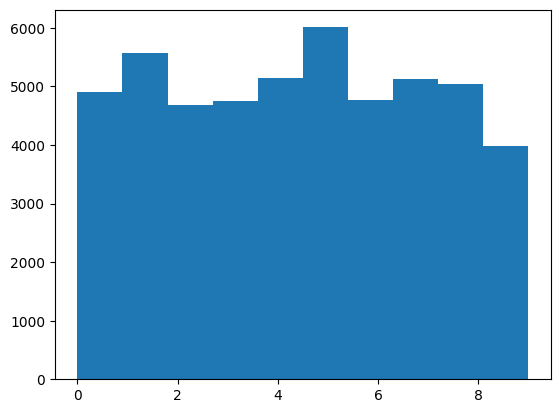

In [60]:
# import matplotlib.pyplot as plt
# plt.hist(predicted, bins=10)
# classes = ["aquatic", "plants", "food", "houshold", "insects", "outdoor_scenes", "large_animals", "medium_animals", "vehicles", "other"]

# print(classes)


In [56]:
len(torch.unique(y))

10

In [ ]:
c = np.zeros((10,10))
for i in range(len(predicted)):    
    c[predicted[i]][labels[i]] += 1

plt.xlabel("PREDICTED")
plt.ylabel("LABEL")
plt.title("Confusion Matrix")
plt.imshow(c, cmap='Greys_r')

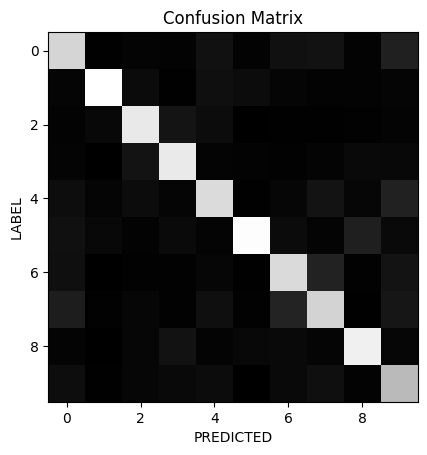

In [61]:
# c = np.zeros((10,10))
# for i in range(len(predicted)):    
#     c[predicted[i]][labels[i]] += 1

# plt.xlabel("PREDICTED")
# plt.ylabel("LABEL")
# plt.title("Confusion Matrix")
# plt.imshow(c, cmap='Greys_r')

In [48]:
diagonal = np.sum(np.diag(c))

print(diagonal/len(predicted))


0.8171414852752881


In [73]:
for x in range(100):    
    top10 = np.argsort(-c[x])[:10]
    all = np.argsort(-c[x])
    print(top10)
    print(-np.sort(-c[x])[:10])  

    # also go and check the complementary   
    for i in all[1:]:
        #print(i, c[x][i], c[i][x])
        print(c[x][i] + c[i][x])







[ 0 57 83 53 10 92 51  7 32 54]
[467.  19.  11.   5.   3.   2.   2.   1.   1.   1.]
31.0
19.0
13.0
4.0
2.0
3.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[ 1 91 18 14 29 27 78 33 73 40]
[455.  12.   3.   3.   2.   2.   1.   1.   1.   1.]
18.0
3.0
3.0
4.0
3.0
1.0
1.0
3.0
1.0
1.0
1.0
2.0
2.0
1.0
1.0
3.0
1.0
2.0
1.0
1.0
3.0
1.0
1.0
1.0
2.0
1.0
5.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
2.0
0.0
5.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
1.0
0.0
[ 2 11 35 98 46 78 36 44 24 65]
[366

In [92]:
costs = []
arrays = []

for x in range(100):    
    # print(c[:,x])
    # print(c[x,:])
    tot = c[:,x]+c[x,:]
    #print(tot)
    sorted = np.argsort(-tot)
    print(sorted[0:11])
    print(tot[sorted][1:11])

    sum_tot = np.sum(tot[sorted][1:11])
    print(sum_tot)

    costs.append(sum_tot)
    arrays.append(sorted[0:11])


[ 0 57 83 53 10 51 92  4 69 77  2]
[31. 19. 13.  4.  3.  2.  1.  1.  1.  1.]
76.0
[ 1 91 62 93 29 50 32 27 18 14 73]
[18.  5.  5.  4.  3.  3.  3.  3.  3.  3.]
50.0
[ 2 11 35 98 46 65 36 25 57 84 44]
[76. 58. 24. 21.  5.  5.  5.  5.  4.  4.]
207.0
[ 3 21 31 55 72  4 19 43 38 15 34]
[32. 28. 28. 27. 22. 21. 12. 12. 11. 10.]
203.0
[ 4 55 74 72  3 50 63 80 27 77 64]
[56. 40. 27. 22. 16. 16. 11. 10.  7.  7.]
212.0
[ 5 25 84 20 89 37 87 39 85 94 91]
[55. 25. 11.  5.  5.  4.  4.  3.  3.  3.]
118.0
[ 6  7 14 79 18 45 26 24 82 93 54]
[19. 12.  9.  9.  8.  7.  7.  6.  6.  5.]
88.0
[ 7 24 79  6 44 18 14 26 41 72 74]
[48. 29. 19.  7.  7.  7.  6.  5.  4.  3.]
135.0
[ 8 48 89 79 46 78 85 38 41 44 70]
[25.  4.  3.  3.  2.  2.  2.  2.  1.  1.]
45.0
[ 9 16 40 86 10 25 83 67 57  6 87]
[20. 10.  6.  5.  5.  4.  4.  3.  3.  2.]
62.0
[10 61 28 22 16 40 32 83 57 51  9]
[70. 30. 17. 14. 10.  7.  7.  7.  5.  5.]
172.0
[11 35  2 46 98 40 64 55 32 31 10]
[80. 76. 75. 49.  5.  4.  4.  4.  3.  2.]
302.0
[12 37 90

In [105]:
print(costs)
ordered_arr = np.argsort(-np.array(costs))
print(np.array(costs)[ordered_arr][:10])

print(np.array(arrays)[ordered_arr][:10])

[76.0, 50.0, 207.0, 203.0, 212.0, 118.0, 88.0, 135.0, 45.0, 62.0, 172.0, 302.0, 108.0, 163.0, 69.0, 108.0, 98.0, 92.0, 103.0, 118.0, 55.0, 100.0, 87.0, 124.0, 98.0, 138.0, 125.0, 142.0, 87.0, 99.0, 214.0, 107.0, 117.0, 121.0, 117.0, 310.0, 98.0, 99.0, 145.0, 39.0, 94.0, 52.0, 92.0, 99.0, 179.0, 123.0, 274.0, 256.0, 67.0, 91.0, 202.0, 63.0, 245.0, 70.0, 93.0, 237.0, 60.0, 109.0, 83.0, 215.0, 115.0, 126.0, 147.0, 98.0, 130.0, 109.0, 80.0, 172.0, 51.0, 61.0, 117.0, 164.0, 223.0, 220.0, 199.0, 44.0, 63.0, 73.0, 114.0, 103.0, 142.0, 160.0, 42.0, 121.0, 91.0, 57.0, 69.0, 83.0, 74.0, 79.0, 121.0, 103.0, 170.0, 133.0, 54.0, 198.0, 227.0, 87.0, 308.0, 95.0]
[310. 308. 302. 274. 256. 245. 237. 227. 223. 220.]
[[35 98 11  2 46 21 40  6 44 38 50]
 [98 35 46 11  2 21 32  3 65 45 36]
 [11 35  2 46 98 40 64 55 32 31 10]
 [46 98 11 35  2 32 21 87 84 13 30]
 [47 52 96 59 33 56 70 37 82 28 26]
 [52 47 59 96 33 56 49 60 37 31 29]
 [55 72  4  3 27 74 95 21 38 80 30]
 [96 47 59 52 33 56 37 18 49 65 74]
 [7

In [23]:
## majority voting for each class
b = np.argmax(a, axis=0)

c = np.zeros((centroids.shape[0],100))
for x in range(100):    
    c[b[x]][x] = 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Majority belonging to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(c, cmap='Greys_r')

NameError: name 'a' is not defined

In [44]:
# use the second matrix as a mask 

false_negative = np.sum(np.ma.array(a,mask=c))
print(false_negative)

15193.0


In [46]:
false_negative/clusters.shape[0]

0.3039572663252241

In [17]:
# map each line to cluster: label to cluster belonging

maps = {}

for i, x in enumerate(c):
    for j, y in enumerate(x):
        if(y==1):
            maps[j] = i
    
print(maps)

{0: 0, 1: 0, 53: 0, 54: 0, 57: 0, 62: 0, 70: 0, 82: 0, 83: 0, 92: 0, 4: 1, 27: 1, 29: 1, 32: 1, 44: 1, 50: 1, 51: 1, 63: 1, 64: 1, 74: 1, 75: 1, 77: 1, 78: 1, 80: 1, 2: 2, 5: 2, 11: 2, 20: 2, 25: 2, 35: 2, 36: 2, 39: 2, 46: 2, 84: 2, 86: 2, 87: 2, 94: 2, 98: 2, 3: 3, 15: 3, 19: 3, 21: 3, 31: 3, 34: 3, 38: 3, 42: 3, 43: 3, 65: 3, 66: 3, 88: 3, 97: 3, 6: 4, 7: 4, 14: 4, 18: 4, 24: 4, 26: 4, 45: 4, 79: 4, 30: 5, 55: 5, 67: 5, 72: 5, 73: 5, 91: 5, 93: 5, 95: 5, 9: 6, 10: 6, 16: 6, 22: 6, 23: 6, 28: 6, 40: 6, 60: 6, 61: 6, 69: 6, 71: 6, 99: 6, 12: 7, 17: 7, 37: 7, 49: 7, 68: 7, 76: 7, 90: 7, 8: 8, 13: 8, 41: 8, 48: 8, 58: 8, 81: 8, 85: 8, 89: 8, 33: 9, 47: 9, 52: 9, 56: 9, 59: 9, 96: 9}


In [28]:
np.sum(c, axis=1)

array([ 8.,  7.,  9.,  7., 19.,  8.,  6., 18.,  6., 12.])